# CLUSTERING

### Importamos las librerías

In [39]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler


### Importamos el dataset y lo limpiamos

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [4]:
filename = "nasa/event/event_wind_summary/event_wind_summary.csv"
fd = pd.read_csv(filename);
fd = clean_dataset(fd);
fd.columns

Index(['ARCHIVED_RECORD_NUMBER', 'SEISMIC_TIME_SOLS', 'ORIGINAL_FILE_NUMBER',
       'ORIGINAL_RECORD_NUMBER', 'DATA_ACQUISITION_SOL',
       'DATA_ACQUISITION_HOUR', 'DATA_ACQUSITION_MINUTE',
       'DATA_ACQUISITION_SECOND', 'MEDIAN_X_AXIS', 'FIRST_X_AXIS',
       'MAXIMUM_X_AXIS', 'MINIMUM_X_AXIS', 'RMS_X_AXIS_X100',
       'RMS_Y_AXIS_X100', 'RMS_Z_AXIS_X100', 'MEAN_X_AXIS_CROSSINGS',
       'MEAN_Y_AXIS_CROSSINGS', 'MEAN_Z_AXIS_CROSSINGS', 'METEO_TIME_SOLS',
       'WINDSPEED', 'PRESSURE', 'WIND_DIRECTION', 'AIR_TEMPERATURE',
       'WIND_SEISMIC_INTERVAL'],
      dtype='object')

### Normalizamos el dataset completo

In [5]:
#df_norm = ( fd - fd.min()) / ( fd.max() - fd.min() )
df_norm = StandardScaler().fit_transform(fd.astype(float))
df_norm= pd.DataFrame(df_norm, columns=fd.columns)

### Buscamos grupos de variables dependientes

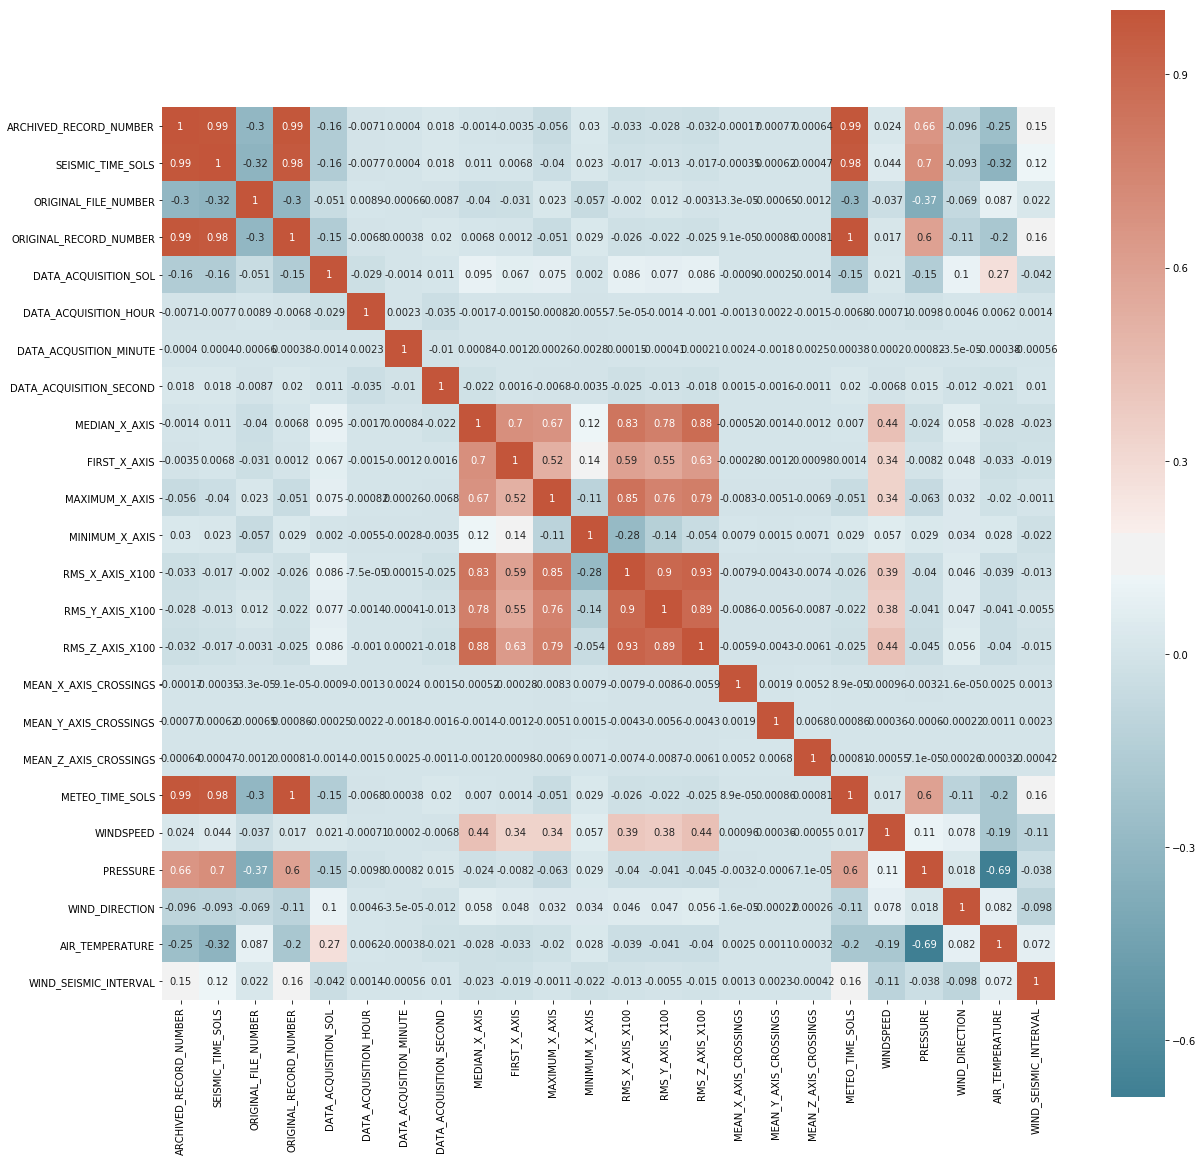

In [6]:
f, ax = plt.subplots(figsize=(20,20)) 
corr = df_norm.corr()
sns.heatmap(corr,square=True ,cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax , annot = True) 

# Generamos los grupos con variable tiempo independiente

In [7]:
#GRUPO 1 -> 
gp_1 = ['MEDIAN_X_AXIS', 'FIRST_X_AXIS',
       'MAXIMUM_X_AXIS','RMS_X_AXIS_X100',
       'RMS_Y_AXIS_X100', 'RMS_Z_AXIS_X100','WINDSPEED']

#GRUPO 2 -> 
gp_2 = ['PRESSURE','AIR_TEMPERATURE']

#GRUPO 3 ( INDEPENDIENTES ) -> 
gp_3 = ['SEISMIC_TIME_SOLS','MINIMUM_X_AXIS','MEAN_X_AXIS_CROSSINGS',
       'MEAN_Y_AXIS_CROSSINGS', 'MEAN_Z_AXIS_CROSSINGS','WIND_DIRECTION']

### Aplicamos PCA para modelo con tiempo independiente y creamos el nucleo de entrenamiento

In [8]:
# Indicamos el numero de columnas que tiene que salir 
sklearn_pca = sklearnPCA(n_components=1)

# Aplicamos PCA para los dos conjuntos que hemos hecho a partir de analisis de correlaciones
datos_pca_gp_1 = sklearn_pca.fit_transform(df_norm[gp_1])
datos_pca_gp_2 = sklearn_pca.fit_transform(df_norm[gp_2])

# Unimos para formar el dataset de entrenamiento del algoritmo de clustering

core = df_norm[gp_3]; 
core['sismo'] = datos_pca_gp_1; 
core['pre_temp'] = datos_pca_gp_2; 
core[core == np.nan].count()

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


SEISMIC_TIME_SOLS        0
MINIMUM_X_AXIS           0
MEAN_X_AXIS_CROSSINGS    0
MEAN_Y_AXIS_CROSSINGS    0
MEAN_Z_AXIS_CROSSINGS    0
WIND_DIRECTION           0
sismo                    0
pre_temp                 0
dtype: int64

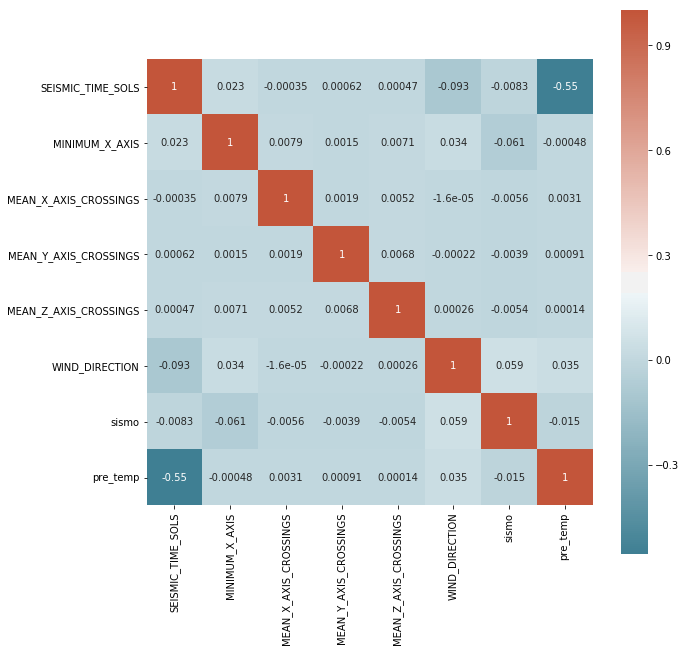

In [9]:
f, ax = plt.subplots(figsize=(10,10)) 
corr = core.corr()
sns.heatmap(corr,square=True ,cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax , annot = True) 

### Creamos el modelo K-Means con variable tiempo independiente, lo entrenamos y sacamos las etiquetas

In [10]:
# Entrenamos el modelo
model_kmeans = KMeans(n_clusters=5).fit(core)

# Sacamos los centroides
centroids = model_kmeans.cluster_centers_

# Sacamos los tags del dataset
labels = model_kmeans.predict(core)


In [48]:
# Asignamos las categorias al dataset original sin normalizar

fd["TAG_KM"] = labels; 


In [49]:
fd.groupby("TAG_KM").mean()

,ARCHIVED_RECORD_NUMBER,SEISMIC_TIME_SOLS,ORIGINAL_FILE_NUMBER,ORIGINAL_RECORD_NUMBER,DATA_ACQUISITION_SOL,DATA_ACQUISITION_HOUR,DATA_ACQUSITION_MINUTE,DATA_ACQUISITION_SECOND,MEDIAN_X_AXIS,FIRST_X_AXIS,...,MEAN_X_AXIS_CROSSINGS,MEAN_Y_AXIS_CROSSINGS,MEAN_Z_AXIS_CROSSINGS,METEO_TIME_SOLS,WINDSPEED,PRESSURE,WIND_DIRECTION,AIR_TEMPERATURE,WIND_SEISMIC_INTERVAL,TAG
TAG_KM,,,,,,,,,,,,,,,,,,,,,
0,178664.397396,787.918182,26981.642927,343.412994,9.235003,28.939390,29.503146,50.756147,1.956632,2.048925,...,15.006837,15.017629,15.008809,343.807383,3.225788,9.090469,145.334223,180.090514,35998.654464,0
1,148696.801980,685.238416,33277.603762,291.255050,13.361188,28.668515,29.497030,50.601188,24.787327,28.502574,...,14.885545,14.918218,14.877228,291.816580,13.708574,8.605389,168.082396,183.043406,11198.339406,1
2,112113.705532,561.149056,55540.185161,207.860550,11.317324,30.012587,29.830739,50.823783,2.572044,-0.537595,...,14.809540,15.053660,14.820802,208.340110,3.493127,8.362955,124.224710,182.532395,67914.179861,2
3,134780.820955,642.145036,31225.869967,252.960407,12.390389,29.272943,29.488789,50.666083,8.740685,9.941319,...,14.990081,15.006543,14.997166,253.482978,8.286392,8.712156,163.553751,180.462124,27929.949487,3
4,36707.430063,244.952091,61276.156553,50.593164,12.366956,29.325596,29.449283,50.618339,2.189391,2.222722,...,15.020871,15.025387,15.022113,51.114821,2.469529,7.536163,149.066472,210.611364,29164.930543,4


### Estudio de categorias

Text(0, 0.5, 'PRESSURE')

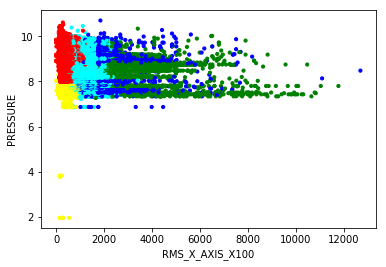

In [42]:
plt.scatter(X.RMS_X_AXIS_X100, X.PRESSURE, c=asignar, s=10)
plt.xlabel('RMS_X_AXIS_X100')
plt.ylabel('PRESSURE')

Text(0, 0.5, 'SEISMIC_TIME_SOLS')

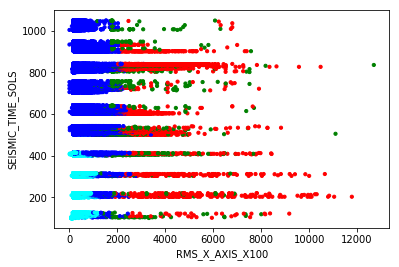

In [56]:
X = fd.copy()

fig = plt.figure()
#ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar=[]
for row in labels:
    asignar.append(colores[row])

plt.scatter(X.RMS_X_AXIS_X100, X.SEISMIC_TIME_SOLS, c=asignar, s=10)
plt.xlabel('RMS_X_AXIS_X100')
plt.ylabel('SEISMIC_TIME_SOLS')

In [ ]:
PROBLEMAS
    * No podemos usar la variable tiempo como variable independiente a las demás, influye demasiado en el modelo.
    * Opciones:
        - Incluirla o meterla dentro del subgrupo variables atmosféricas ( No merece la pena ).
        - Desincluirla ( EL resultado será mas fino ).
    
    Tenemos un total de tres modelos diferentes para comparación de datos.

# Generamos los grupos sin tener en cuenta la variable tiempo

In [71]:
#GRUPO 1 -> 
gp_1_dep = ['MEDIAN_X_AXIS', 'FIRST_X_AXIS',
       'MAXIMUM_X_AXIS','RMS_X_AXIS_X100',
       'RMS_Y_AXIS_X100', 'RMS_Z_AXIS_X100','WINDSPEED']

#GRUPO 2 -> 
gp_2_dep = ['PRESSURE','AIR_TEMPERATURE']

#GRUPO 3 ( INDEPENDIENTES ) -> 
gp_3_dep = ['MINIMUM_X_AXIS','MEAN_X_AXIS_CROSSINGS',
       'MEAN_Y_AXIS_CROSSINGS', 'MEAN_Z_AXIS_CROSSINGS','WIND_DIRECTION']

# Indicamos el numero de columnas que tiene que salir 
sklearn_pca = sklearnPCA(n_components=1)

# Aplicamos PCA para los dos conjuntos que hemos hecho a partir de analisis de correlaciones
datos_pca_gp_1_dep = sklearn_pca.fit_transform(df_norm[gp_1_dep])
datos_pca_gp_2_dep = sklearn_pca.fit_transform(df_norm[gp_2_dep])

# Unimos para formar el dataset de entrenamiento del algoritmo de clustering

core_dep = df_norm[gp_3_dep]; 
core_dep['sismo'] = datos_pca_gp_1_dep; 
core_dep['pre_temp'] = datos_pca_gp_2_dep; 
core_dep[core_dep == np.nan].count()

# Entrenamos el modelo
model_kmeans_dep = KMeans(n_clusters=5).fit(core_dep)

# Sacamos los centroides
centroids_dep = model_kmeans_dep.cluster_centers_

# Sacamos los tags del dataset
labels_dep = model_kmeans_dep.predict(core_dep)

# Lo incluimos en el modelo principal como variable dependiente
fd["TAG_KM_DEP"] = labels_dep; 

# Agrupamos por esta ultima y vemos las medias
fd.groupby("TAG_KM_DEP").mean()

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ARCHIVED_RECORD_NUMBER,SEISMIC_TIME_SOLS,ORIGINAL_FILE_NUMBER,ORIGINAL_RECORD_NUMBER,DATA_ACQUISITION_SOL,DATA_ACQUISITION_HOUR,DATA_ACQUSITION_MINUTE,DATA_ACQUISITION_SECOND,MEDIAN_X_AXIS,FIRST_X_AXIS,...,MEAN_Y_AXIS_CROSSINGS,MEAN_Z_AXIS_CROSSINGS,METEO_TIME_SOLS,WINDSPEED,PRESSURE,WIND_DIRECTION,AIR_TEMPERATURE,WIND_SEISMIC_INTERVAL,TAG,TAG_KM
TAG_KM_DEP,,,,,,,,,,,,,,,,,,,,,
0,173543.408106,771.159586,27339.723476,331.944308,8.803957,28.900920,29.508038,50.766586,1.960099,2.058593,...,15.015125,15.005770,332.321191,3.253806,9.091748,137.823887,177.345685,42052.044918,0.041419,0.041419
1,133745.983778,637.111244,32233.377693,250.849624,12.306695,29.266367,29.501610,50.645711,8.698671,9.893627,...,14.998679,14.995170,251.368797,8.242389,8.686103,163.125947,181.146656,28129.604805,2.995336,2.995336
2,148621.902159,684.991880,33266.874431,291.090909,13.360269,28.681719,29.487027,50.601109,24.790454,28.502080,...,14.917211,14.876807,291.652412,13.704785,8.605097,168.023034,183.045474,11268.586849,1.001188,1.001188
3,112236.910691,561.523240,55467.312417,208.135126,11.305777,29.975764,29.874834,50.823373,2.575033,-0.542165,...,15.057769,14.819057,208.614194,3.497450,8.363228,124.274436,182.559661,67690.396746,1.999336,1.999336
4,62258.542429,337.147764,56697.767936,105.148498,12.946158,29.366472,29.439886,50.617640,2.151321,2.176767,...,15.032080,15.027699,105.693669,2.488723,7.702494,164.168033,212.890320,17418.437290,3.496246,3.496246


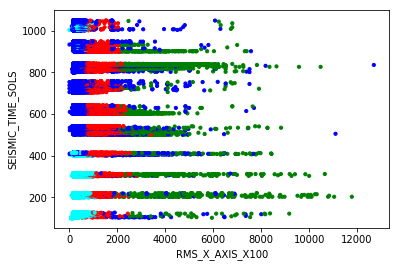

In [75]:
# Comparación entre 
X = fd.copy()
fig = plt.figure();
#ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar_dep=[]
for row in labels_dep:
    asignar_dep.append(colores[row])

# Clusters creados por KMeans tras aplicar variable tiempo dentro de pca
plt.scatter(X.RMS_X_AXIS_X100, X.SEISMIC_TIME_SOLS, c=asignar_dep, s=10)
plt.xlabel('RMS_X_AXIS_X100')
plt.ylabel('SEISMIC_TIME_SOLS')


plt.show()



# Conclusiones

* Usemos o no la variable tiempo en el modelo, estará explicitamente relacionado con los valores
* Viendo la matriz de correlaciones, vemos que no dependen del tiempo cuando se puede ver claramente que sí, esto es debido a que hay cierta relación no lineal entre variables. Una finalidad de nuestro análisis es encontrar este tipo de relaciones.

* Si no lo usamos para entrenar nuestro modelo Kmeans, el modelo es mas fino.
* Ahora tendriamos que estudiar las estadísticas para dar una categoría de los datos a cada TAG.